In [1]:
import pandas as pd
import pyvista as pv
import numpy as np
import vtk
import meshio
from itkwidgets import view

**Import well location**
-----------------------------------
import data from a .csv

In [2]:
wellLoc = pd.read_csv('../data/TestData_3DvisPyvi/inputData//TV-HFM_Wells_1Location.csv',header=1,index_col=0,
                      usecols=[0,2,3,6],skipfooter=1,engine='python')
wellLoc.head()

,Easting,Northing,Altitude_ft
Bore,,,
A. Isaac,2333140.95,1372225.65,3204.0
A. Woodbridge,2321747.00,1360096.95,2967.2
A.D. Watkins,2315440.16,1342141.86,3168.3
A.L. Clark; 1,2276526.30,1364860.74,2279.1
A.L. Clark; 2,2342620.87,1362980.46,3848.6


**Change coordinate system and elevation**
-------------------------------

In [3]:
from pyproj import Transformer
transformer = Transformer.from_crs('esri:102605','epsg:32611',always_xy=True)
points = list(zip(wellLoc.Easting,wellLoc.Northing))
coordsWgsUTM = np.array(list(transformer.itransform(points)))
wellLoc['EastingUTM']=coordsWgsUTM[:,0]
wellLoc['NorthingUTM']=coordsWgsUTM[:,1]
wellLoc['Elevation_m']=wellLoc['Altitude_ft']*3
wellLoc.head()

,Easting,Northing,Altitude_ft,EastingUTM,NorthingUTM,Elevation_m
Bore,,,,,,
A. Isaac,2333140.95,1372225.65,3204.0,575546.628834,4.820355e+06,9612.0
A. Woodbridge,2321747.00,1360096.95,2967.2,564600.366582,4.807827e+06,8901.6
A.D. Watkins,2315440.16,1342141.86,3168.3,558944.843404,4.789664e+06,9504.9
A.L. Clark; 1,2276526.30,1364860.74,2279.1,519259.006159,4.810959e+06,6837.3
A.L. Clark; 2,2342620.87,1362980.46,3848.6,585351.150270,4.811460e+06,11545.8


**Generation of surface as delanuay tringulation**
--------

In [4]:
elevArray = wellLoc.loc[:,['EastingUTM','NorthingUTM','Elevation_m']].to_numpy()
elevCloud = pv.PolyData(elevArray)
surf = elevCloud.delaunay_2d()
surf.save('../data/TestData_3DvisPyvi/outputData/elevSurf.vtk',binary=False)



**Plot the toporaphic surface**

In [5]:
grid = pv.read('../data/TestData_3DvisPyvi/outputData/elevSurf.vtk')

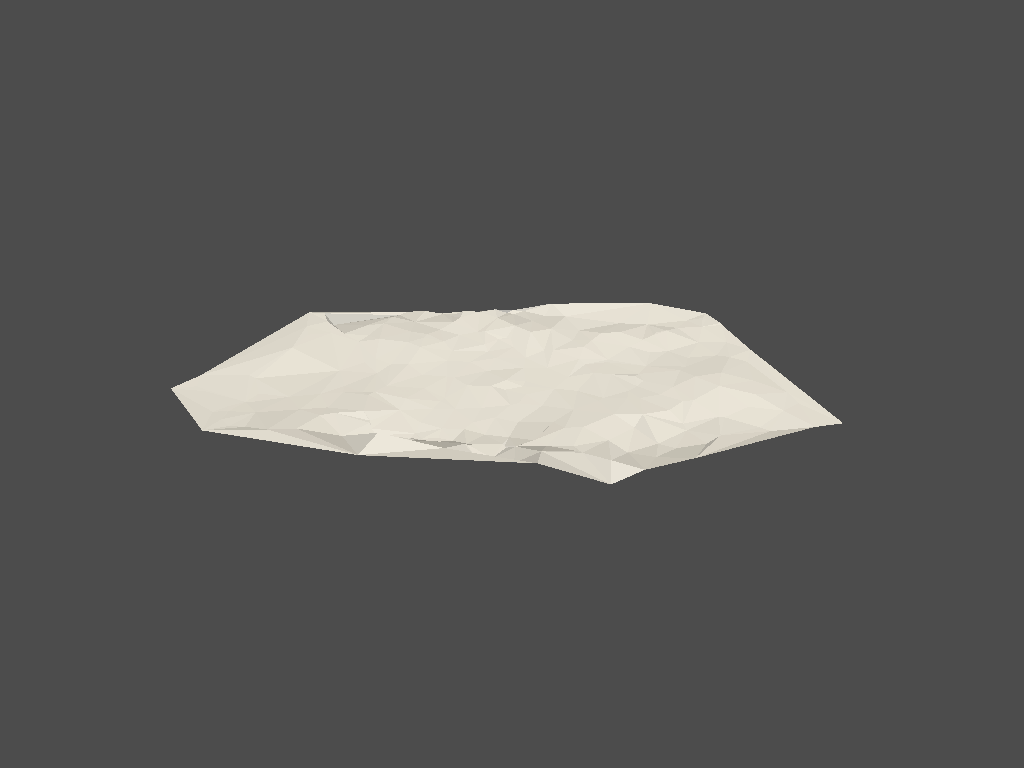

In [6]:
grid.plot(show_scalar_bar=False, show_axes=True)

In [7]:
#pl = pv.PlotterITK()
#pl.add_mesh(grid)
#pl.show()

**Import well lithology**
-----
Import data from a .csv

In [8]:
wellLito = pd.read_csv('../data/TestData_3DvisPyvi/inputData/TV-HFM_Wells_2Lithology.csv',skipfooter=1,
                       header=1,index_col=0, usecols=[0,1,2,3],engine='python')
wellLito.head()

,Depth_top_L,Depth_bot_L,PrimaryLith
Bore,,,
A. Isaac,0.0,1.0,Soil
A. Isaac,1.0,53.0,Sand
A. Isaac,53.0,248.0,Basalt
A. Isaac,248.0,265.0,Sand
A. Isaac,265.0,323.0,Basalt


**Create a dictionary for the lito code**
------


In [9]:
litoDict = {}
i=0
for lito in wellLito.PrimaryLith.unique():
    litoDict[lito]=i
    i+=1
litoDict

{'Soil': 0,
 'Sand': 1,
 'Basalt': 2,
 'Granite': 3,
 'Hardpan/Caliche': 4,
 'Cinders/Scoria': 5,
 'Gravel': 6,
 'Clay': 7,
 'Talc/Soapstone': 8,
 'Shale': 9,
 'Lignite/Coal/Peat': 10,
 'Sandstone': 11,
 'Lime': 12,
 'Claystone': 13,
 'Mud': 14,
 'Ash/Tuff': 15,
 'Mudstone': 16,
 'Rhyolite': 17,
 'Siltstone': 18,
 'Silt': 19,
 'Shell': 20,
 'Conglomerate': 21,
 'Volcanics': 22,
 'Chert': 23,
 'Pyrite': 24,
 'Limestone/marl': 25,
 'Wood': 26,
 'Andesite': 27}

**Identify lito by the code on the dataframe**
----

In [10]:
wellLito['litoCode']=wellLito.PrimaryLith
wellLito = wellLito.replace({"litoCode": litoDict})
wellLito.head()

,Depth_top_L,Depth_bot_L,PrimaryLith,litoCode
Bore,,,,
A. Isaac,0.0,1.0,Soil,0
A. Isaac,1.0,53.0,Sand,1
A. Isaac,53.0,248.0,Basalt,2
A. Isaac,248.0,265.0,Sand,1
A. Isaac,265.0,323.0,Basalt,2


**Generation of list arrays for the vtk**
-----

In [11]:
offsetList = []
linSec = []
linVerts = []

i=0
for index, values in wellLito.iterrows():
    x, y, z =wellLoc.loc[index][['EastingUTM','NorthingUTM','Elevation_m']]
    topLito = z - (values.Depth_top_L)*5 #*x to fix the size of the object
    botLito = z- (values.Depth_bot_L)*5 #*x to fix the size of the object
    cellVerts = [[x,y,topLito],[x,y,botLito]]
    offsetList.append(i*3)         
    linSec = linSec + [2,2*i,2*i+1]
    linVerts = linVerts + cellVerts
    i +=1

offsetArray = np.array(offsetList)
linArray = np.array(linSec)
cellType = np.ones([i])*3
vertArray = np.array(linVerts)

**create the unstructured grid and assign lito code**

In [12]:
grid2 = pv.UnstructuredGrid(linArray, cellType, vertArray)
grid2.cell_arrays["values"] = wellLito.litoCode.values
grid2.save('../data/TestData_3DvisPyvi/outputData/wellLito.vtu',binary=False)

**Plot the wells**
-----

In [13]:
mesh = meshio.read('../data/TestData_3DvisPyvi/outputData/wellLito.vtu') #to creat a mesh from a .vtu

In [14]:
mesh

<meshio mesh object>
  Number of points: 11456
  Number of cells:
    line: 5728
  Cell data: values

**First way to display the objects**


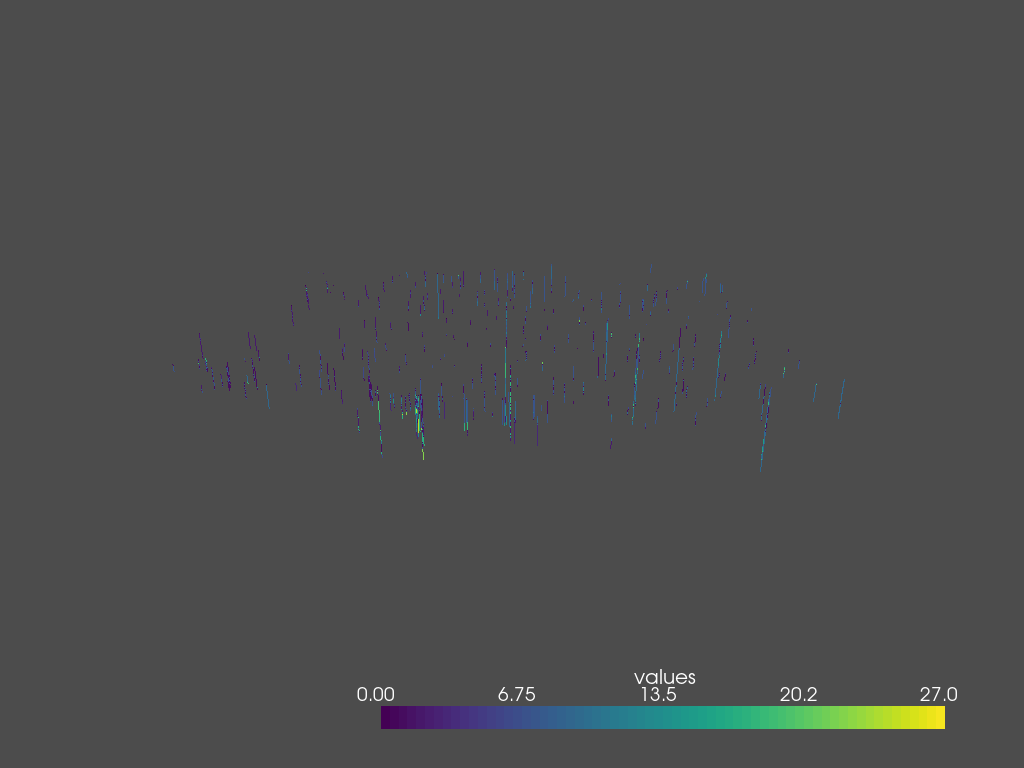

In [15]:
grid2.plot()


**Second way to display the wells and to interact with the view using ITK**

In [16]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…